In [18]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

In [19]:
df = pd.read_csv("shop_ease_fashion_dataset.csv")
df

,order_id,order_date,customer_id,age_group,gender,city_tier,customer_tenure_months,product_category,order_value,quantity,...,payment_mode,acquisition_channel,channel_cost,delivery_time_days,return_status,cancellation_reason,refund_amount,complaint_flag,sub_category,brand
0,ORD006253,2025-10-02,CUST02806,35-44,Female,Tier-3,43,Formal,4002.22,1,...,COD,Influencer,81.67,4,No,NaN,0.0,0,Trousers,BrandA
1,ORD004685,2025-08-09,CUST05257,35-44,Male,Tier-2,53,Formal,2074.76,1,...,Card,Referral,6.22,6,No,NaN,0.0,0,Trousers,BrandE
2,ORD001732,2025-05-10,CUST05370,18-24,Male,Tier-3,57,Accessories,542.91,1,...,Wallet,Google,41.45,5,No,NaN,0.0,0,Watches,BrandE
3,ORD004743,2025-01-16,CUST04652,18-24,Male,Tier-1,28,Loungewear,931.91,1,...,UPI,Instagram,26.03,1,No,NaN,0.0,0,Nightwear,BrandC
4,ORD004522,2025-11-07,CUST02292,25-34,Female,Tier-1,41,Casual,2075.93,1,...,Card,Influencer,124.41,1,No,NaN,0.0,0,Dresses,BrandD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,ORD005735,2025-11-12,CUST01589,18-24,Female,Tier-1,16,Accessories,339.09,2,...,NetBanking,Email,7.56,1,No,NaN,0.0,0,Bags,BrandE
9996,ORD005192,2025-10-15,CUST04253,25-34,Female,Tier-1,53,Formal,2863.50,1,...,UPI,Google,37.50,2,No,NaN,0.0,0,Office Dresses,BrandF
9997,ORD005391,2025-04-09,CUST02000,18-24,Male,Tier-3,57,Loungewear,1698.43,2,...,COD,Referral,5.99,4,No,NaN,0.0,0,Comfort Tees,BrandA
9998,ORD000861,2025-09-06,CUST00158,25-34,Male,Tier-1,22,Casual,2126.32,1,...,UPI,Google,39.30,2,No,NaN,0.0,0,Jeans,BrandB


In [20]:
df['return_flag'] = (
    df['return_status']
    .str.strip()
    .str.lower()
    .eq('returned')
    .astype(int)
)

In [21]:
df['return_flag'].value_counts(normalize=True) * 100

return_flag
0    93.12
1     6.88
Name: proportion, dtype: float64

In [22]:
features = [
    'age_group',
    'city_tier',
    'customer_tenure_months',
    'product_category',
    'sub_category',
    'brand',
    'discount_percent',
    'acquisition_channel',
    'channel_cost',
    'delivery_time_days',
    'payment_mode'
]

X = df[features]
y = df['return_flag']

In [23]:
categorical_cols = [
    'age_group',
    'city_tier',
    'product_category',
    'sub_category',
    'brand',
    'acquisition_channel',
    'payment_mode'
]

numerical_cols = [
    'customer_tenure_months',
    'discount_percent',
    'channel_cost',
    'delivery_time_days'
]

In [24]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numerical_cols)
    ]
)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [26]:
# If not installed
# pip install imbalanced-learn

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [27]:
smote = SMOTE(
    sampling_strategy=0.4,   # minority becomes 40% of majority (don’t force 50%)
    random_state=42
)

In [28]:
model_smote = ImbPipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('smote', smote),
        ('classifier', LogisticRegression(max_iter=1000))
    ]
)

In [29]:
model_smote.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['age_group', 'city_tier',
                                                   'product_category',
                                                   'sub_category', 'brand',
                                                   'acquisition_channel',
                                                   'payment_mode']),
                                                 ('num', 'passthrough',
                                                  ['customer_tenure_months',
                                                   'discount_percent',
                                                   'channel_cost',
                                                   'delivery_time_days'])])),
                ('smote', SMOTE(random_state=42, sampling_strategy=0.4)),
                ('classifier', LogisticRegression(max_iter=1000))])

In [30]:
y_prob_smote = model_smote.predict_proba(X_test)[:, 1]
y_pred_smote = (y_prob_smote >= 0.3).astype(int)

print(classification_report(y_test, y_pred_smote))
print("ROC AUC:", roc_auc_score(y_test, y_prob_smote))

              precision    recall  f1-score   support

           0       0.94      0.67      0.78      1862
           1       0.10      0.47      0.16       138

    accuracy                           0.65      2000
   macro avg       0.52      0.57      0.47      2000
weighted avg       0.89      0.65      0.74      2000

ROC AUC: 0.6067614688896154


In [31]:
from sklearn.metrics import classification_report

for t in [0.2, 0.25, 0.3, 0.35]:
    y_pred = (y_prob_smote >= t).astype(int)
    print(f"\nThreshold: {t}")
    print(classification_report(y_test, y_pred))


Threshold: 0.2
              precision    recall  f1-score   support

           0       0.96      0.33      0.50      1862
           1       0.08      0.80      0.15       138

    accuracy                           0.37      2000
   macro avg       0.52      0.57      0.32      2000
weighted avg       0.90      0.37      0.47      2000


Threshold: 0.25
              precision    recall  f1-score   support

           0       0.95      0.51      0.66      1862
           1       0.09      0.66      0.16       138

    accuracy                           0.52      2000
   macro avg       0.52      0.58      0.41      2000
weighted avg       0.89      0.52      0.63      2000


Threshold: 0.3
              precision    recall  f1-score   support

           0       0.94      0.67      0.78      1862
           1       0.10      0.47      0.16       138

    accuracy                           0.65      2000
   macro avg       0.52      0.57      0.47      2000
weighted avg       0.89  

## Final Model Selection

#### Logistic Regression with SMOTE applied on training data and a probability threshold of 0.30 was selected as the final model, as it maximizes early detection of return-prone orders while maintaining operational feasibility

In [32]:
FINAL_THRESHOLD = 0.30

In [34]:
df_test = X_test.copy()
df_test['return_flag'] = y_test
df_test['predicted_prob'] = y_prob_smote
df_test['risk_flag'] = np.where(
    df_test['predicted_prob'] >= FINAL_THRESHOLD,
    'High Risk',
    'Low Risk'
)

df_test.groupby('risk_flag')['return_flag'].mean() * 100

risk_flag
High Risk    9.502924
Low Risk     5.547112
Name: return_flag, dtype: float64

In [35]:
# Get feature names after preprocessing
feature_names = (
    model_smote
    .named_steps['preprocessor']
    .get_feature_names_out()
)

# Get coefficients from logistic regression
coefficients = (
    model_smote
    .named_steps['classifier']
    .coef_[0]
)

# Create importance dataframe
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
}).sort_values('coefficient', ascending=False)

feature_importance

,feature,coefficient
48,cat__payment_mode_COD,0.734096
27,cat__sub_category_Pajama Sets,0.438857
36,cat__sub_category_Watches,0.361743
10,cat__product_category_Ethnic,0.346252
18,cat__sub_category_Ethnic Sets,0.339782
7,cat__product_category_Accessories,0.246056
26,cat__sub_category_Office Dresses,0.204833
20,cat__sub_category_Gym Shorts,0.137003
4,cat__city_tier_Tier-1,0.123942
41,cat__brand_BrandE,0.123768


In [36]:
feature_importance['abs_coeff'] = feature_importance['coefficient'].abs()

top_features = (
    feature_importance
    .sort_values('abs_coeff', ascending=False)
    .head(10)
    [['feature', 'coefficient']]
)

top_features

,feature,coefficient
48,cat__payment_mode_COD,0.734096
25,cat__sub_category_Nightwear,-0.520240
50,cat__payment_mode_NetBanking,-0.481042
6,cat__city_tier_Tier-3,-0.447109
12,cat__product_category_Loungewear,-0.440049
27,cat__sub_category_Pajama Sets,0.438857
34,cat__sub_category_Tracks,-0.390097
36,cat__sub_category_Watches,0.361743
10,cat__product_category_Ethnic,0.346252
18,cat__sub_category_Ethnic Sets,0.339782


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Final threshold (locked decision)
FINAL_THRESHOLD = 0.30

# Create test dataframe
df_test = X_test.copy()
df_test['actual_return'] = y_test
df_test['predicted_prob'] = y_prob_smote

# Risk flag
df_test['risk_group'] = np.where(
    df_test['predicted_prob'] >= FINAL_THRESHOLD,
    'High Risk',
    'Low Risk'
)

# Calculate actual return rate by risk group
risk_summary = (
    df_test.groupby('risk_group')['actual_return']
    .mean()
    .reset_index()
)

risk_summary['actual_return'] = risk_summary['actual_return'] * 100
risk_summary

,risk_group,actual_return
0,High Risk,9.502924
1,Low Risk,5.547112


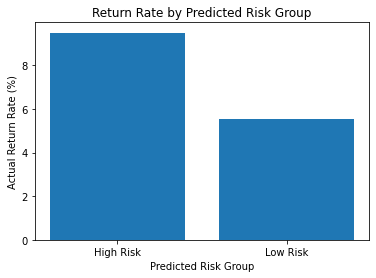

In [38]:
plt.figure()
plt.bar(
    risk_summary['risk_group'],
    risk_summary['actual_return']
)

plt.title('Return Rate by Predicted Risk Group')
plt.ylabel('Actual Return Rate (%)')
plt.xlabel('Predicted Risk Group')

plt.show()

In [39]:
from sklearn.metrics import recall_score

thresholds = np.arange(0.1, 0.6, 0.05)
recalls = []

for t in thresholds:
    y_pred = (y_prob_smote >= t).astype(int)
    recalls.append(recall_score(y_test, y_pred))

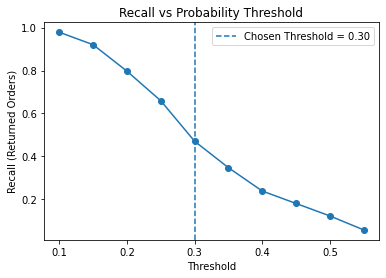

In [40]:
plt.figure()
plt.plot(thresholds, recalls, marker='o')

plt.axvline(
    x=FINAL_THRESHOLD,
    linestyle='--',
    label='Chosen Threshold = 0.30'
)

plt.title('Recall vs Probability Threshold')
plt.xlabel('Threshold')
plt.ylabel('Recall (Returned Orders)')
plt.legend()

plt.show()

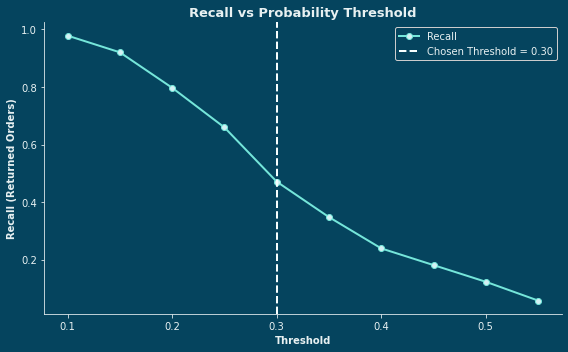

In [43]:
import matplotlib.pyplot as plt

BG_COLOR = "#05445e"
TEXT_COLOR = "#e8f1f2"     # cold white
LINE_COLOR = "#75e6da"     # cold aqua
MARKER_COLOR = "#d4f1f4"   # icy blue

plt.figure(figsize=(8, 5))
ax = plt.gca()

# Set background colors
ax.set_facecolor(BG_COLOR)
plt.gcf().set_facecolor(BG_COLOR)

# Plot recall curve
plt.plot(
    thresholds,
    recalls,
    marker='o',
    color=LINE_COLOR,
    markerfacecolor=MARKER_COLOR,
    linewidth=2,
    label='Recall'
)

# Threshold line
plt.axvline(
    x=FINAL_THRESHOLD,
    linestyle='--',
    linewidth=2,
    color="#f6fefe",
    label='Chosen Threshold = 0.30'
)

# Titles and labels
plt.title(
    'Recall vs Probability Threshold',
    color=TEXT_COLOR,
    fontsize=13,
    weight='bold'
)
plt.xlabel('Threshold', color=TEXT_COLOR, weight='bold')
plt.ylabel('Recall (Returned Orders)', color=TEXT_COLOR, weight='bold')

# Tick colors
plt.tick_params(colors=TEXT_COLOR)

# Legend styling
legend = plt.legend(facecolor=BG_COLOR, framealpha=1)
for text in legend.get_texts():
    text.set_color(TEXT_COLOR)

# Remove top/right spines for clean look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color(TEXT_COLOR)
ax.spines['bottom'].set_color(TEXT_COLOR)

plt.tight_layout()
plt.show()